## Stress prediction based on biometrics data

**Author:** James Twose <br>
**Date:** 20-03-2021 <br>

This dataset comprises of heart rate variability (HRV) and Electrodermal activity (EDA) computed from the SWELL1 and the WESAD2 datasets. It comprises of the following three directories and sub-directories:
1) interim —contains the intermediate data that has been transformed directly from the raw datasets. The raw datasets are not included but they can be obtained from their respective publishers. This folder contains the following major contents: 
    - a) Labels —the ground truth of the experiments. For the details of how these were obtained, please refer to the papers
    included in the root of this director.
    - b) eda —the raw eda signals
    - c) rri —the inter-beat (RR) interval extracted from the electrocardiogram (ECG) signal
2) processed —containes files that were computed from those in the intermidiate directory facilitate the analysis 

3) final —files that were used for creating the model. This directory contains two sub-directories:
    - datasets —contains the combined train, test a nd validation data used to create the model. For more details refer to section II of the paper ”The influence of person-specific biometrics in improving generic stress predictive models”
    - results —contains the detailed results published in ”The influence of person-specific biometrics in improving generic stress predictive models”

### Targets:
- NASA-TLX for the SWELL
- SSSQ for the WESAD

### Import all necessary packages and functions

In [66]:
# utility packages
import sys
import os
import glob
from sinfo import sinfo
# import warnings

# data manipulation packages
import pandas as pd
# from pandas.io.json import json_normalize #package for flattening json in pandas df
# from ast import literal_eval
import numpy as np

# plotting packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# analysis packages
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from jmspack.NLTSA import ts_levels

# internal script
from extras import (swell_eda_features_cols, 
                   swell_eda_target_cols,
                   variance_threshold,
                   nunique_threshold)

In [11]:
sinfo(write_req_file=False)

-----
extras      NA
jmspack     0.0.2
matplotlib  3.3.4
numpy       1.19.2
pandas      1.2.3
seaborn     0.11.1
sinfo       0.3.1
sklearn     0.23.2
-----
IPython             7.21.0
jupyter_client      6.1.7
jupyter_core        4.7.1
jupyterlab          3.0.10
notebook            6.2.0
-----
Python 3.8.8 (default, Feb 24 2021, 13:46:16) [Clang 10.0.0 ]
macOS-10.16-x86_64-i386-64bit
12 logical CPU cores, i386
-----
Session information updated at 2021-03-21 15:35


## Read in data

In [142]:
# df_names_list = glob.glob("dataset/1. processed/eda/swell/*.xlsx")

# df = pd.DataFrame()
# for df_name in df_names_list:
#     current_df = pd.read_excel(df_name)
#     current_df["user_id"] = int(df_name.split("/")[-1].split(".")[0][1:])
#     df = pd.concat([df, current_df], axis=0)

# df = (df
#  .sort_values(["user_id", "Time"])
#  .loc[:, ["user_id"] + [x for x in df.drop("user_id", axis=1).columns.tolist()]]
#  .reset_index(drop=True)
# )

# df.to_csv("swell_eda_all_participants.csv")

df = pd.read_csv("swell_eda_all_participants.csv",
                index_col=0)

In [170]:
df.shape

(104053, 37)

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104053 entries, 0 to 104052
Data columns (total 37 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         104053 non-null  int64  
 1   Time            104053 non-null  float64
 2   MEAN            104053 non-null  float64
 3   MAX             104053 non-null  float64
 4   MIN             104053 non-null  float64
 5   RANGE           104053 non-null  float64
 6   KURT            104053 non-null  float64
 7   SKEW            104053 non-null  float64
 8   MEAN_1ST_GRAD   104053 non-null  float64
 9   STD_1ST_GRAD    104053 non-null  float64
 10  MEAN_2ND_GRAD   104053 non-null  float64
 11  STD_2ND_GRAD    104053 non-null  float64
 12  ALSC            104053 non-null  float64
 13  INSC            104053 non-null  float64
 14  APSC            104053 non-null  float64
 15  RMSC            104053 non-null  float64
 16  MIN_PEAKS       104053 non-null  float64
 17  MAX_PEAKS 

## Exploratory Data Analysis (EDA) 

In [157]:
TARGET = "NasaTLX"

In [158]:
df[swell_eda_features_cols] = pd.DataFrame(MinMaxScaler()
             .fit_transform(
                 df[swell_eda_features_cols]
             ), 
             columns=swell_eda_features_cols)

In [159]:
target_df = (df[["user_id"]+swell_eda_target_cols]
 .groupby(["user_id", "condition"])
 .mean()
             .reset_index()
)

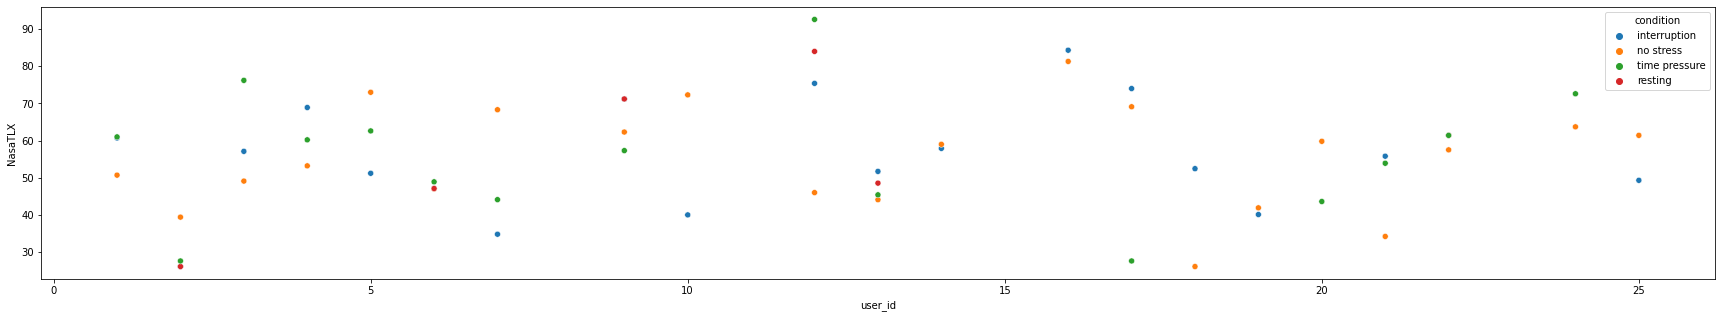

In [175]:
_ = plt.figure(figsize=(30, 5))
_ = sns.scatterplot(x="user_id", 
                    y=TARGET, 
                    hue="condition",
                    data=target_df)

In [179]:
target_df.groupby("user_id").count()[TARGET].value_counts()

2    8
3    8
4    5
0    1
Name: NasaTLX, dtype: int64

In [167]:
target_df.groupby("condition").describe()[TARGET]

count       mean        std   min      25%        50%    75%  \
condition                                                                     
interruption    18.0  55.448197  15.246596  26.1  47.6500  54.123876  66.85   
no stress       21.0  55.209524  13.978838  26.1  46.0000  57.500000  63.70   
resting          6.0  56.391667  20.356827  26.1  47.4625  54.975000  68.75   
time pressure   15.0  55.666227  17.349646  27.6  44.7500  57.300000  62.00   

                     max  
condition                 
interruption   84.319786  
no stress      81.300000  
resting        84.000000  
time pressure  92.600000

In [115]:
# plot_df = (df
#  .loc[df["user_id"] == 1, ["user_id"]+swell_eda_features_cols]
#  .sample(frac=0.05, random_state=69420)
#           .melt(id_vars="user_id"))

# _ = plt.figure(figsize=(20, 5))
# _ = sns.histplot(x="value", 
#                  hue="variable", 
#                  data=plot_df,
#                  bins=20,
#                 kde=True)
# _ = sns.kdeplot(x="value", 
#                  hue="variable", 
#                  data=plot_df
#                )

In [131]:
variance_summary = variance_threshold(df[swell_eda_features_cols], threshold=0.01)

In [136]:
variance_summary[~variance_summary["discard"]]

variance feature_type  discard
MAX        0.010415      float64    False
RANGE      0.010208      float64    False
KURT       0.016189      float64    False
SKEW       0.015628      float64    False
ALSC       0.042752      float64    False
INSC       0.014582      float64    False
MAX_PEAKS  0.011252      float64    False
MAX_ONSET  0.011303      float64    False

In [130]:
# nunique_threshold(df[swell_eda_features_cols], threshold=1500)

1


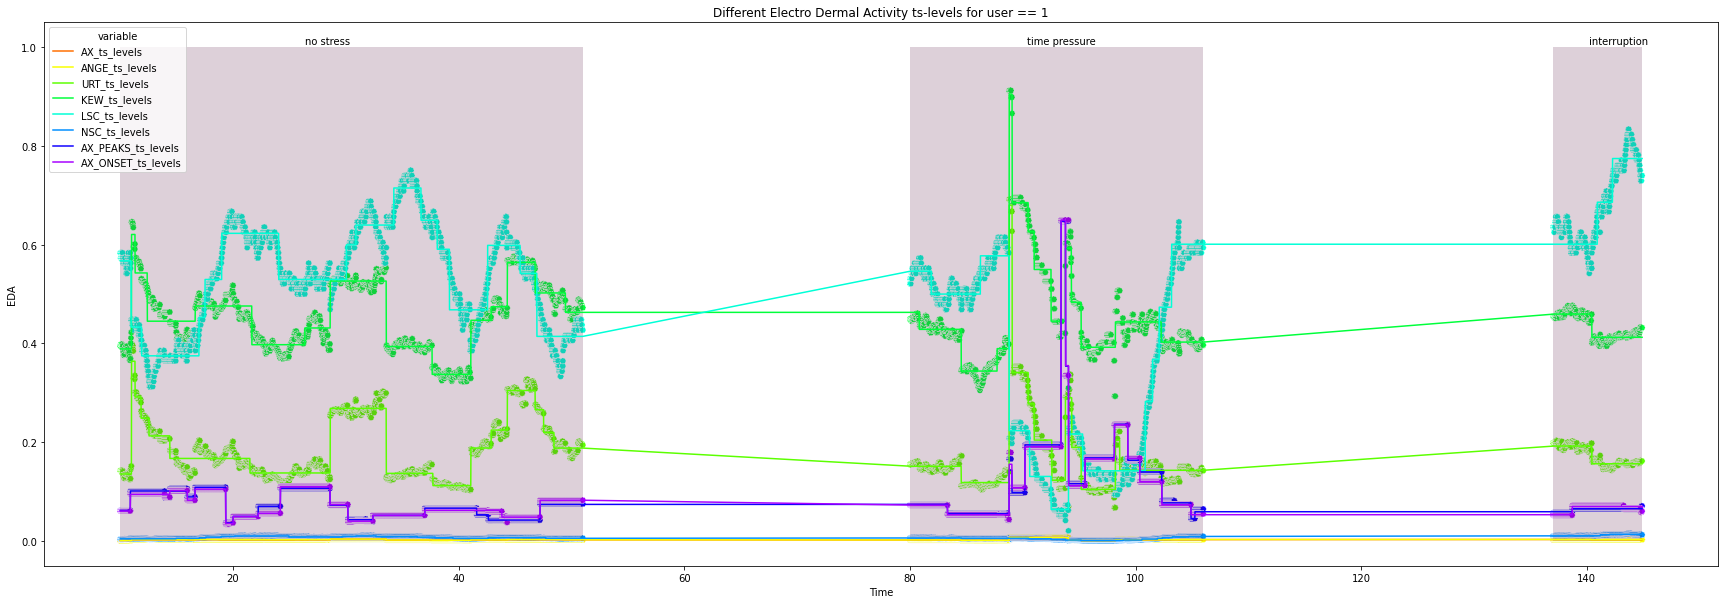

2


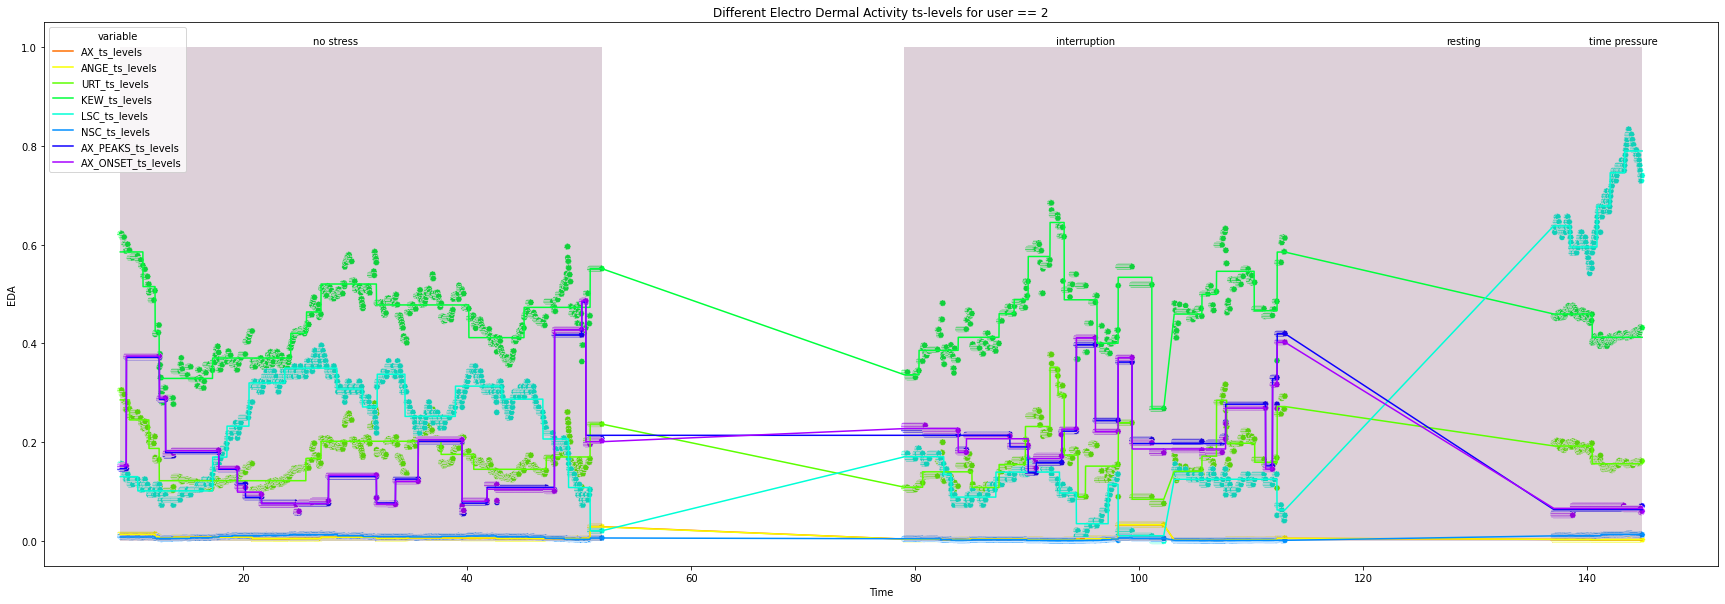

3


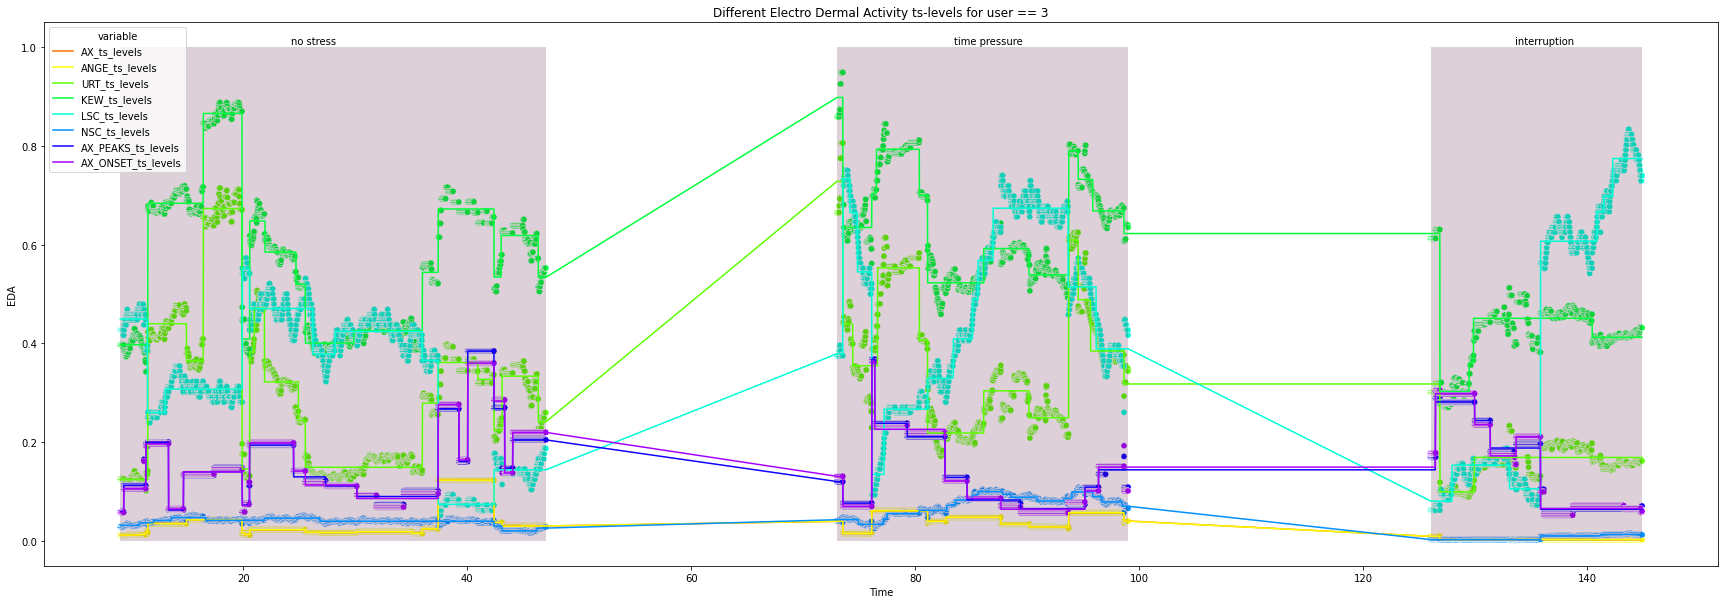

4


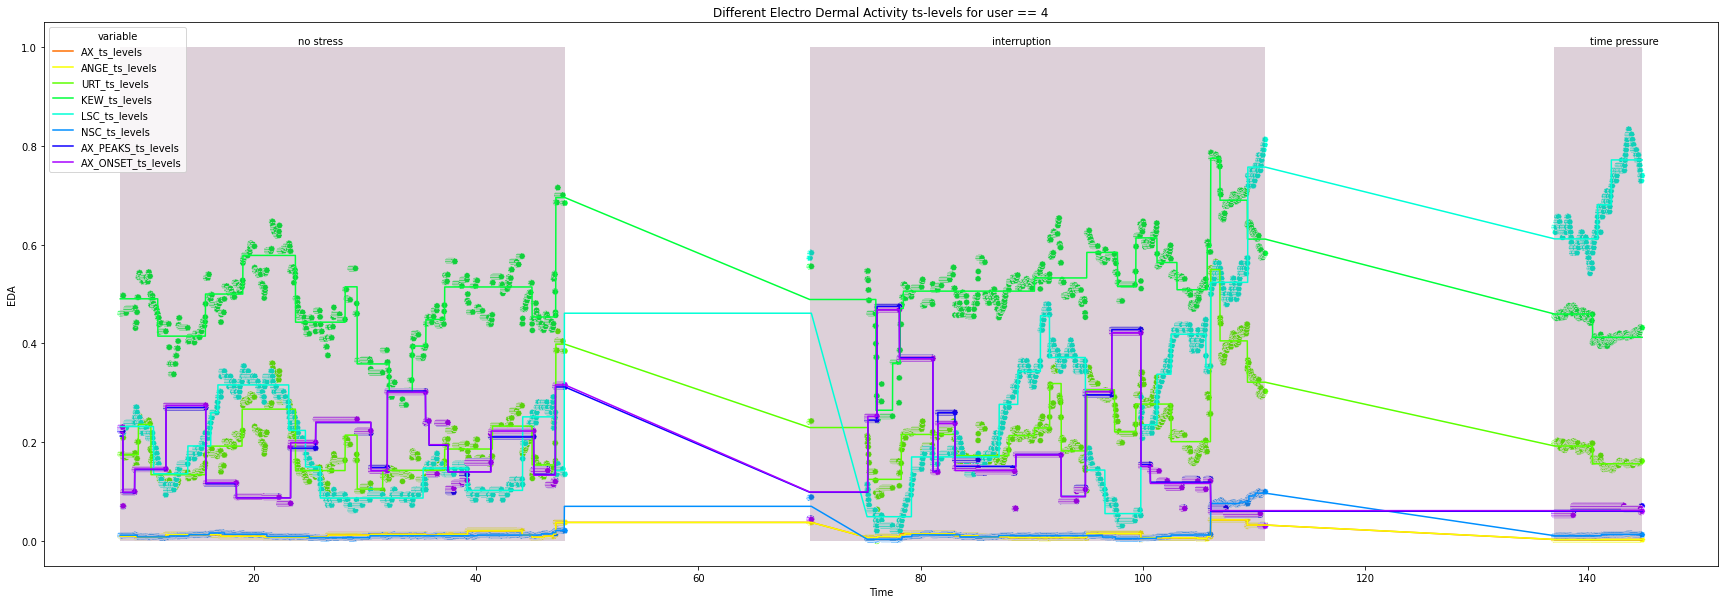

5


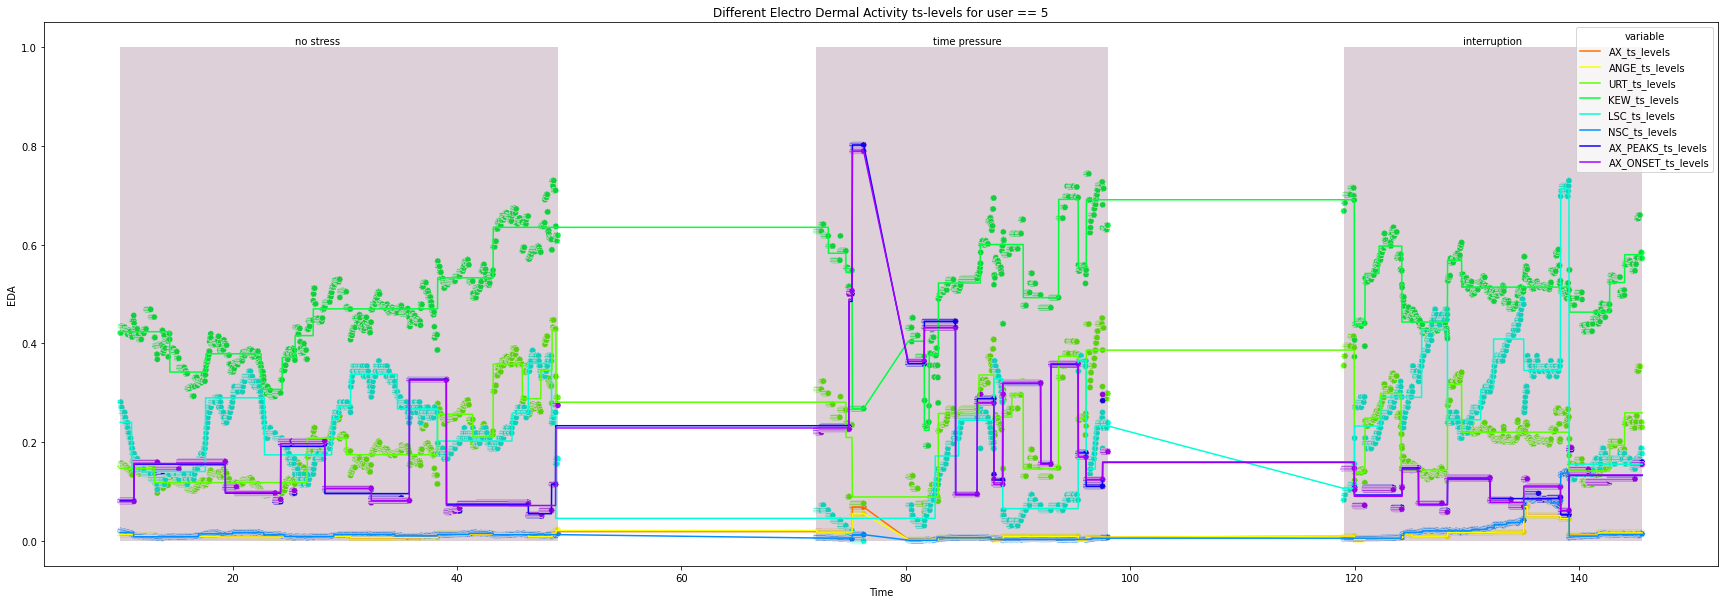

6


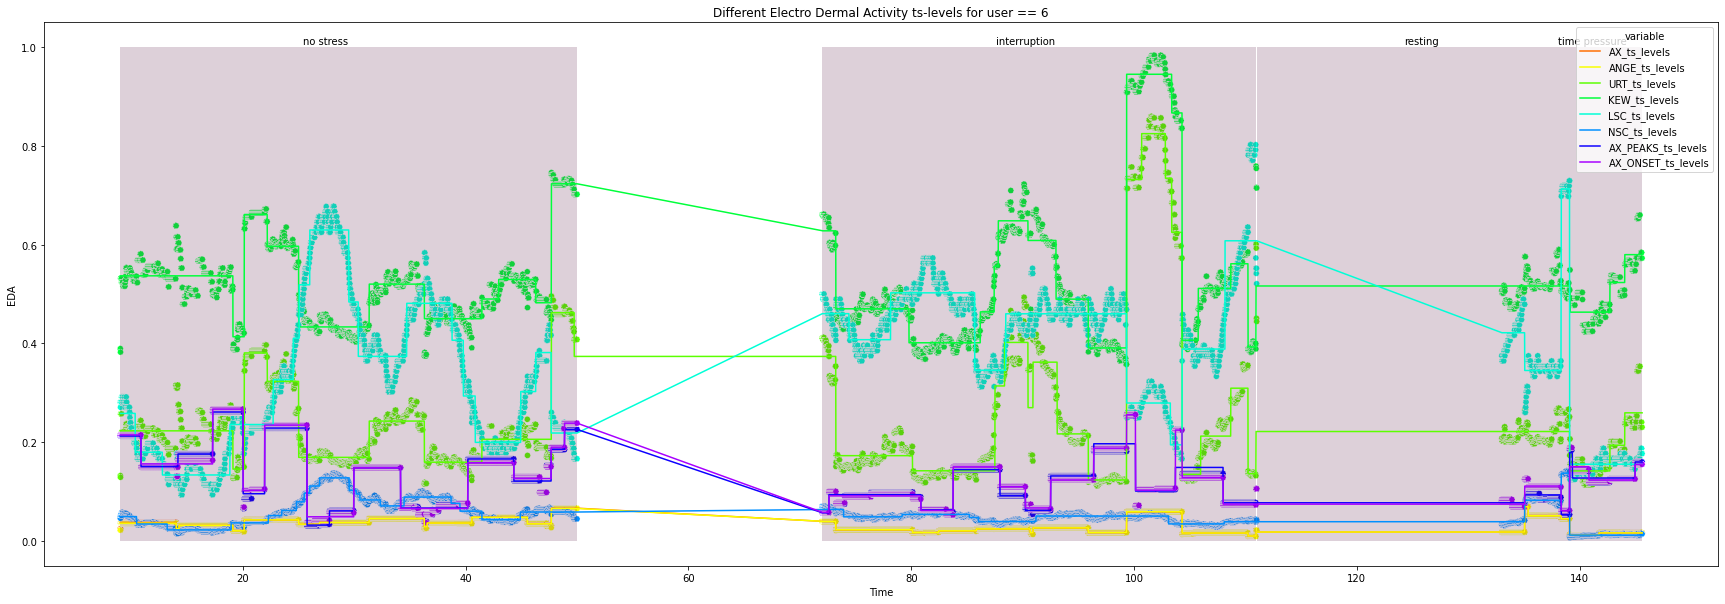

7


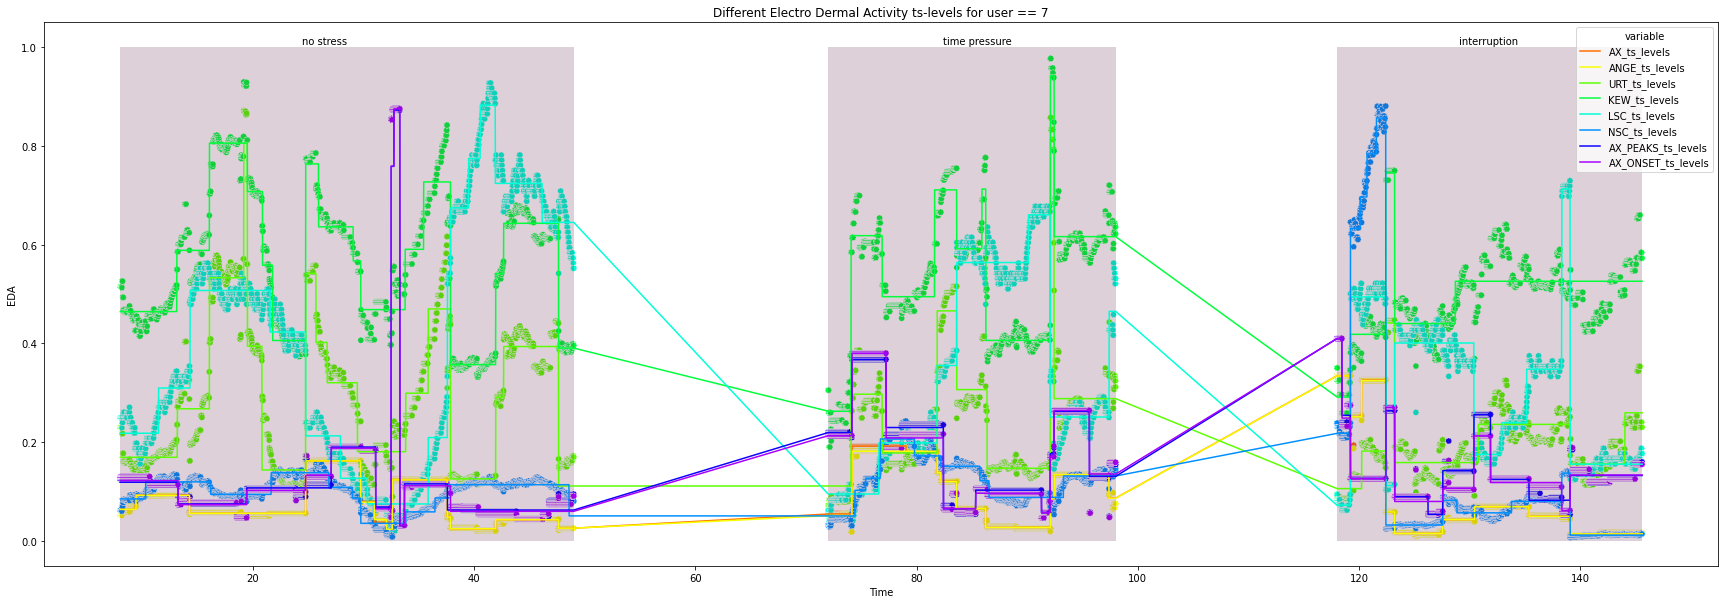

9


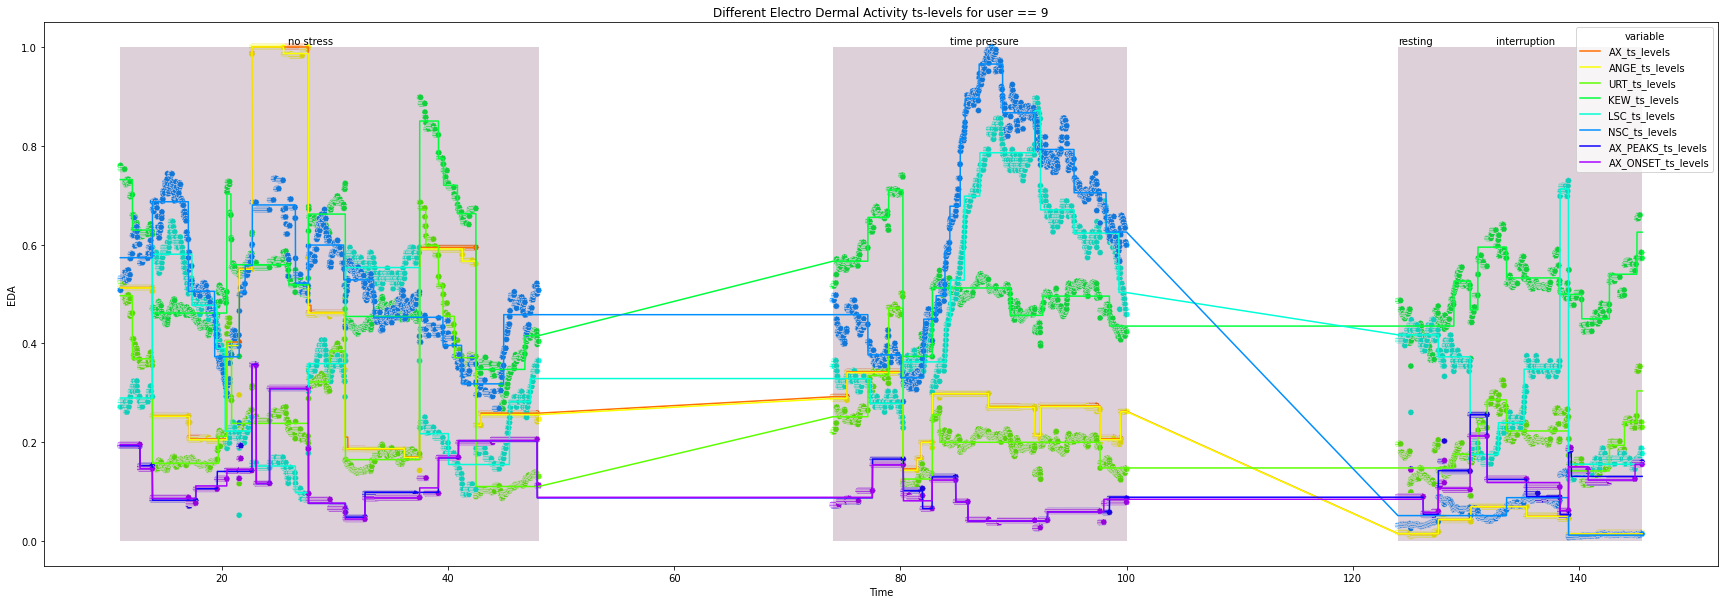

10


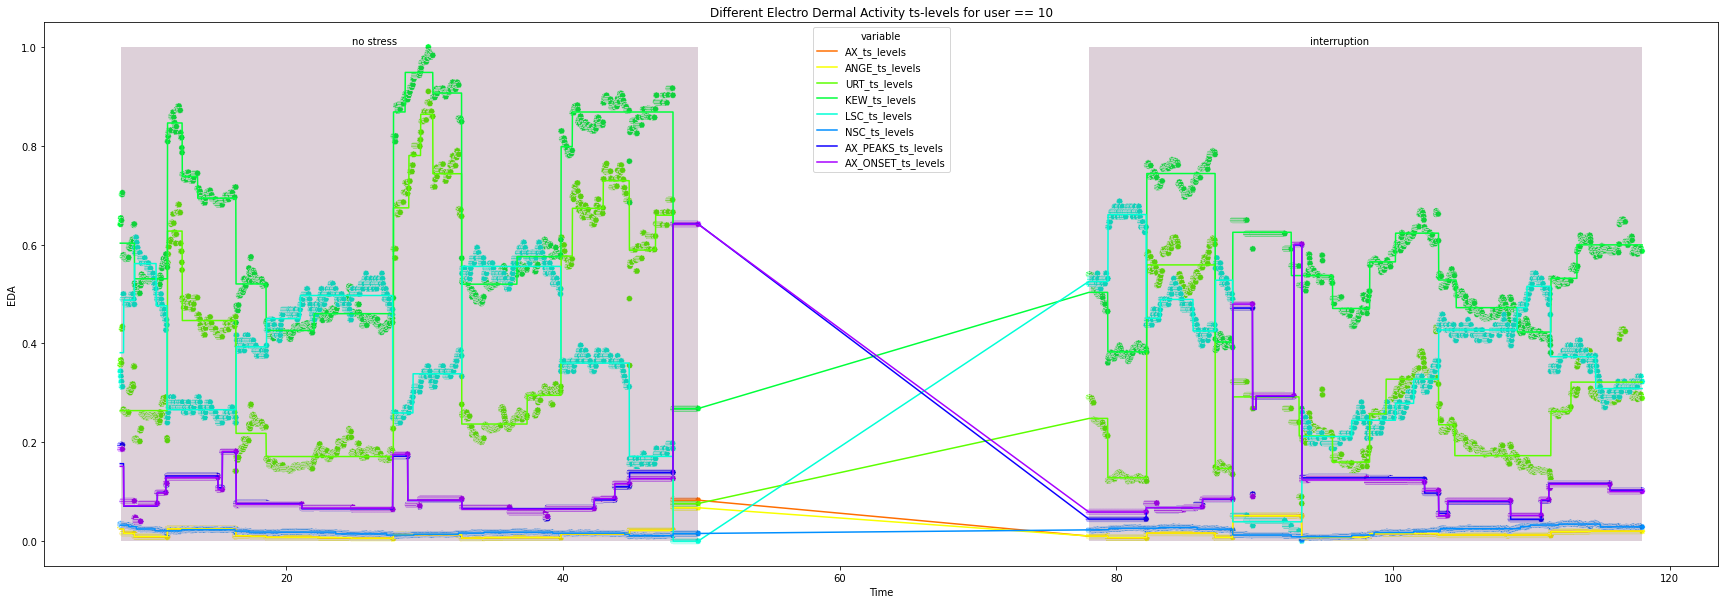

12


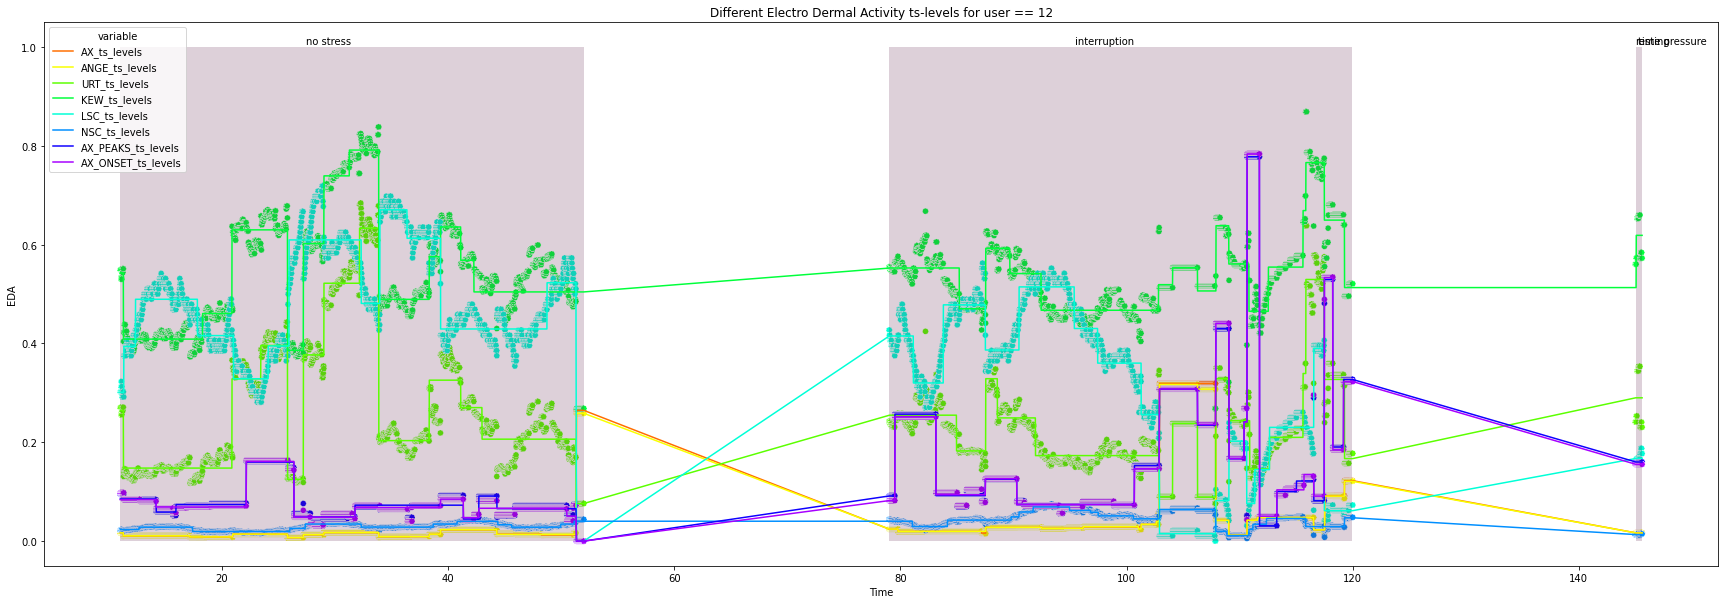

13


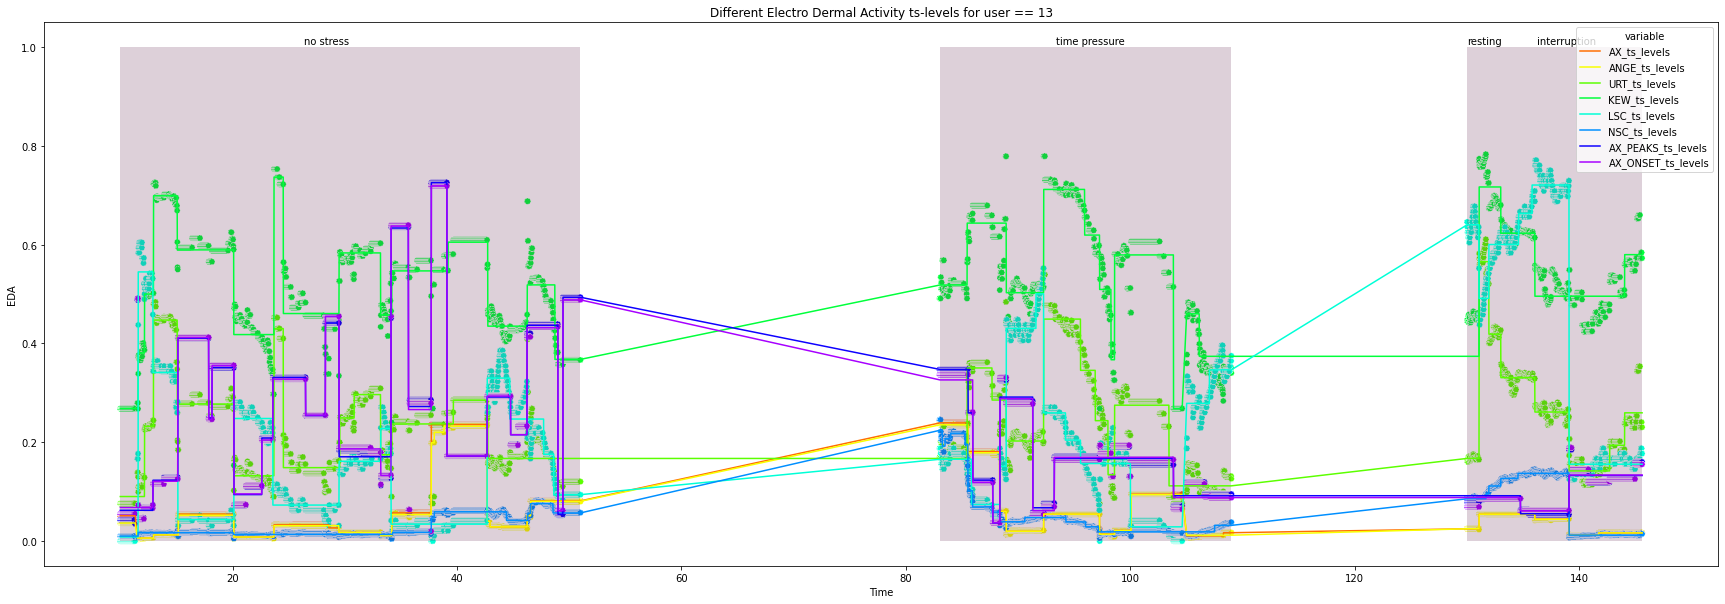

14


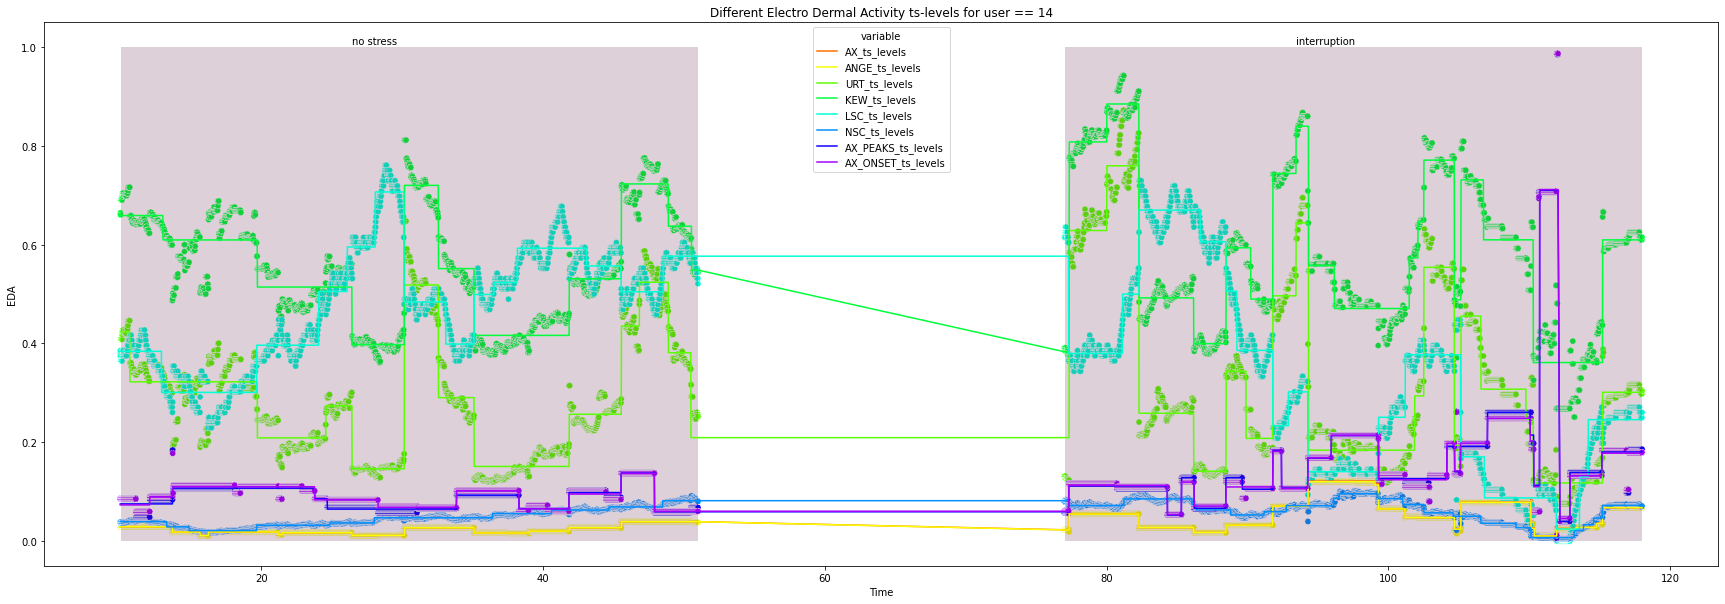

15


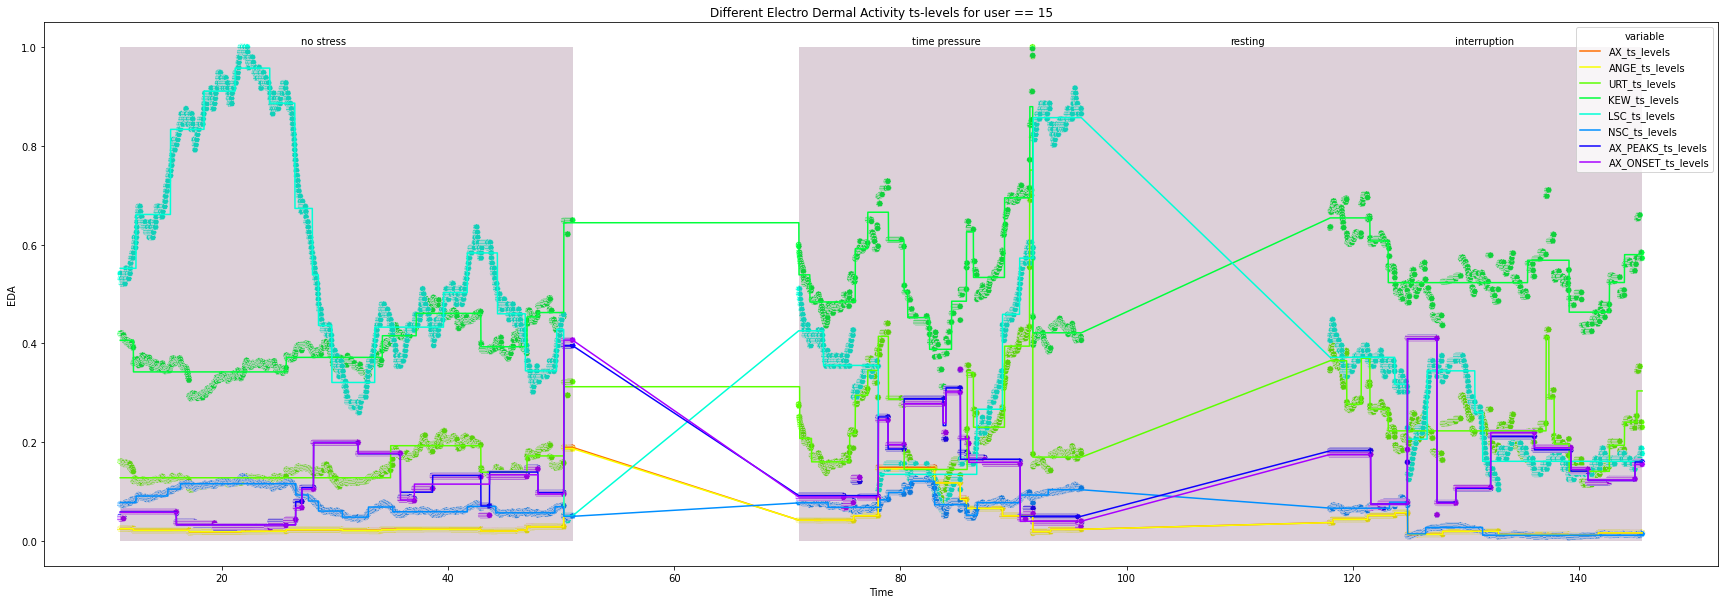

16


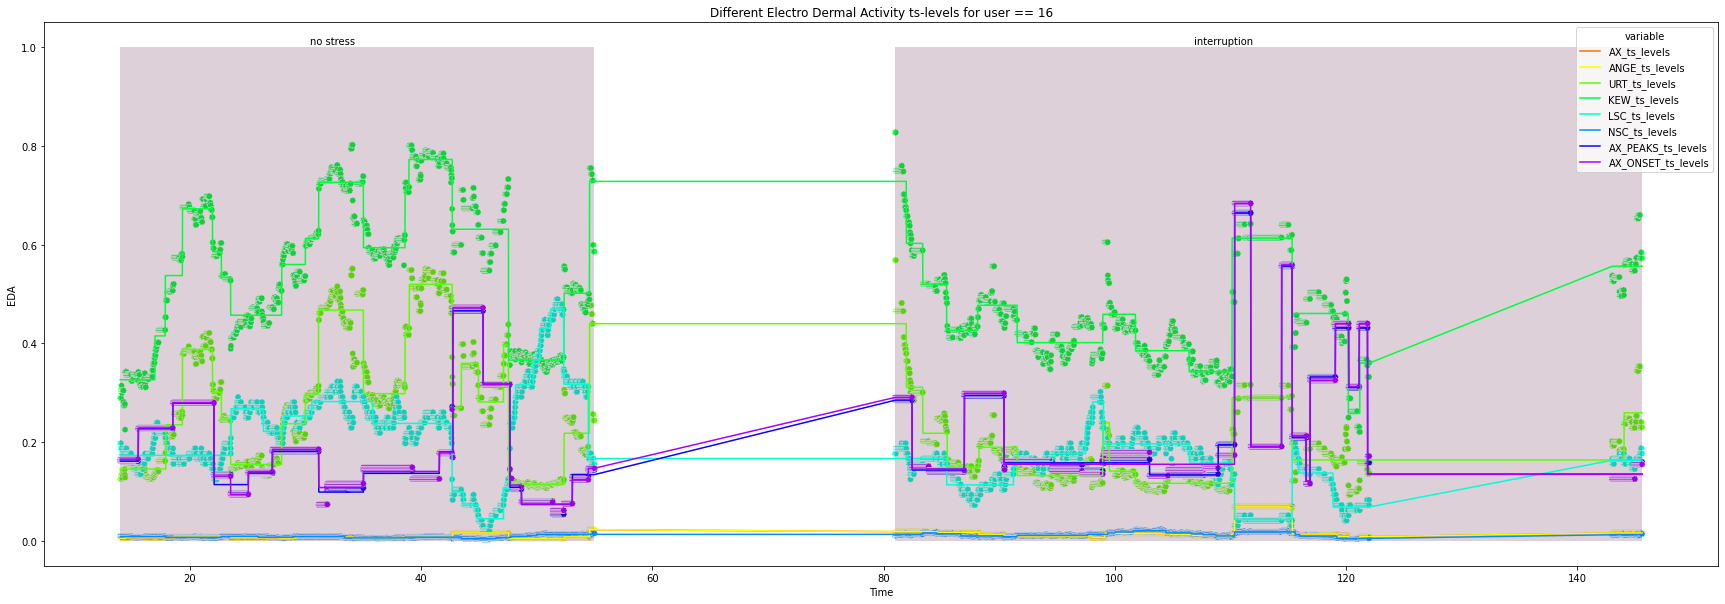

17


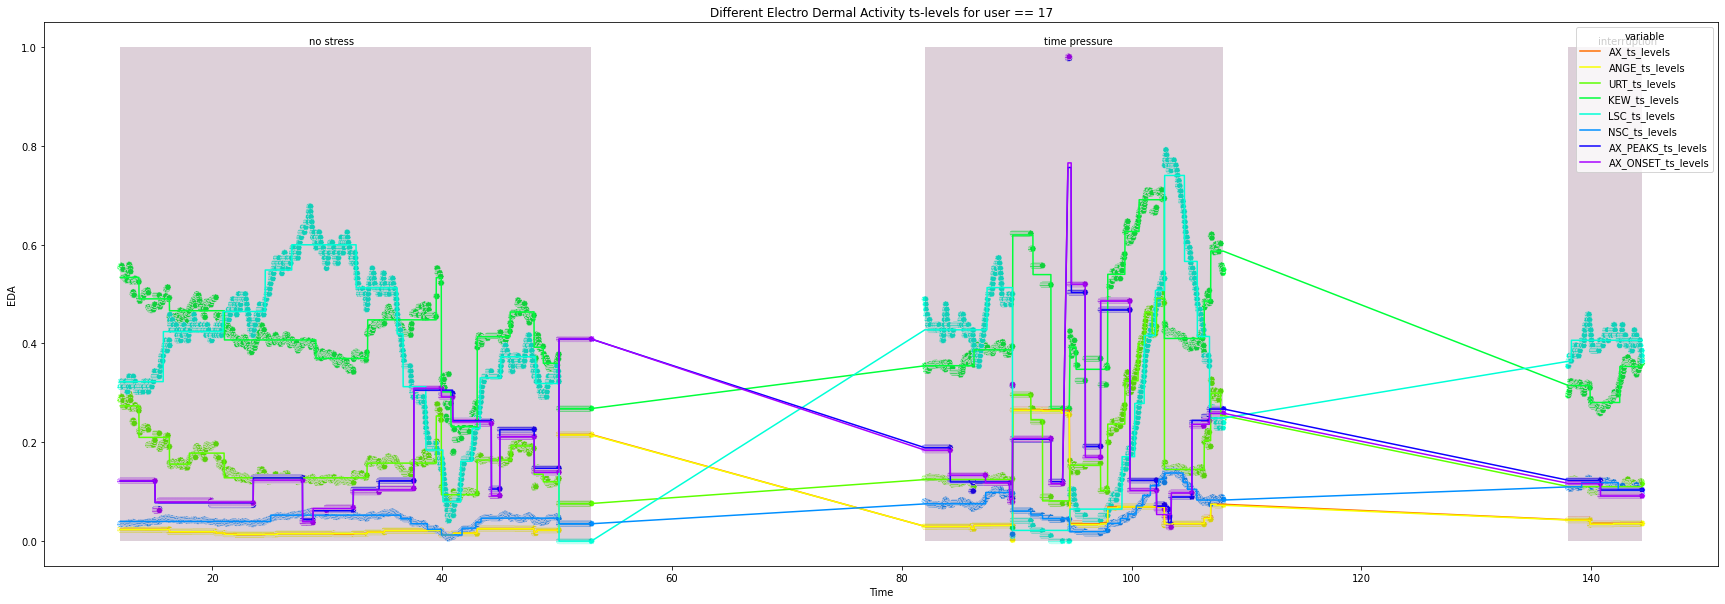

18


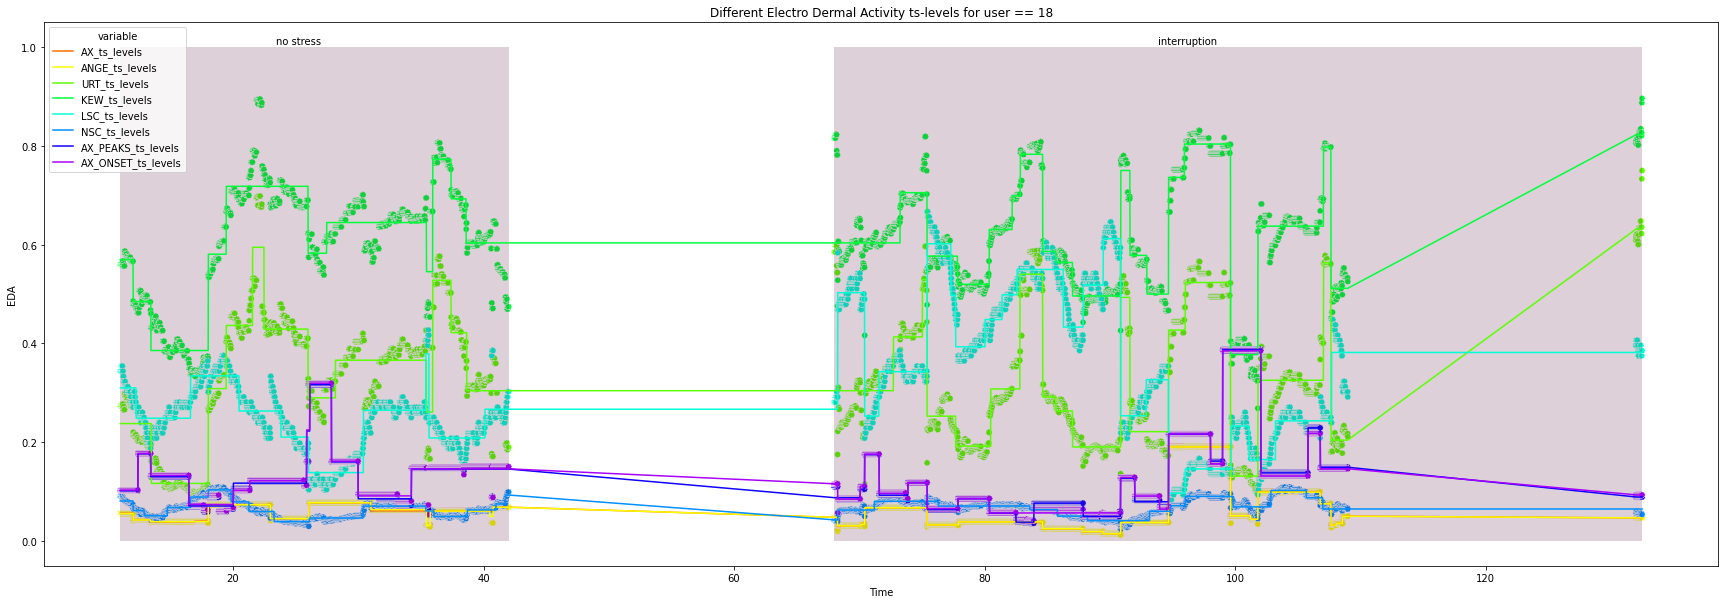

19


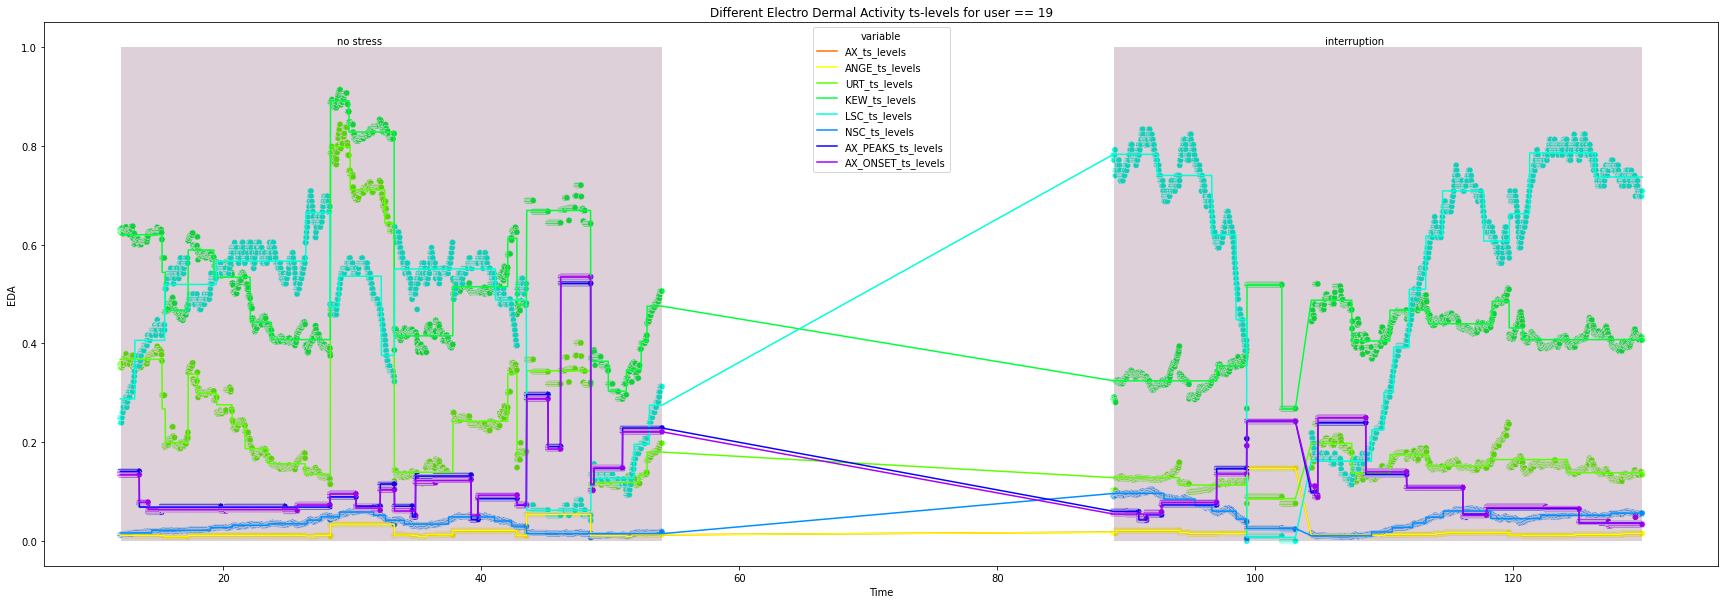

20


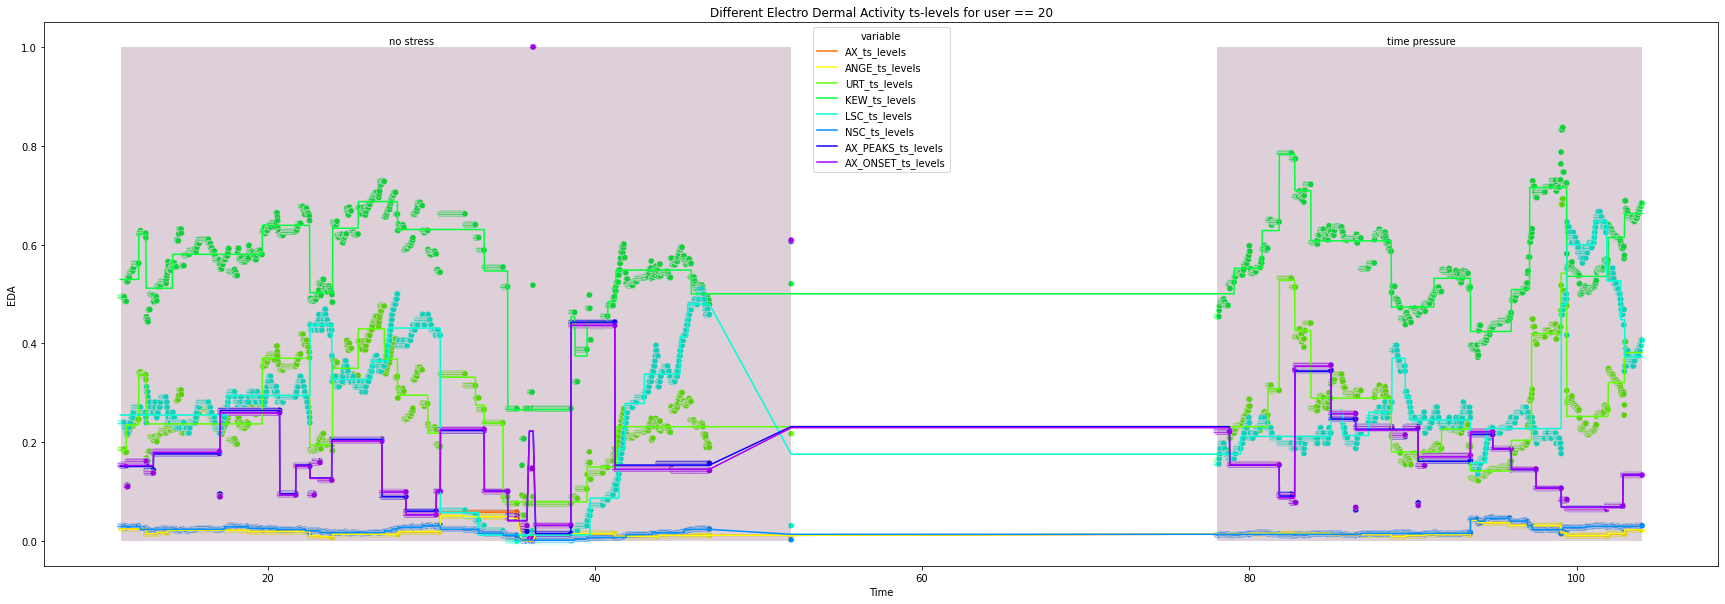

21


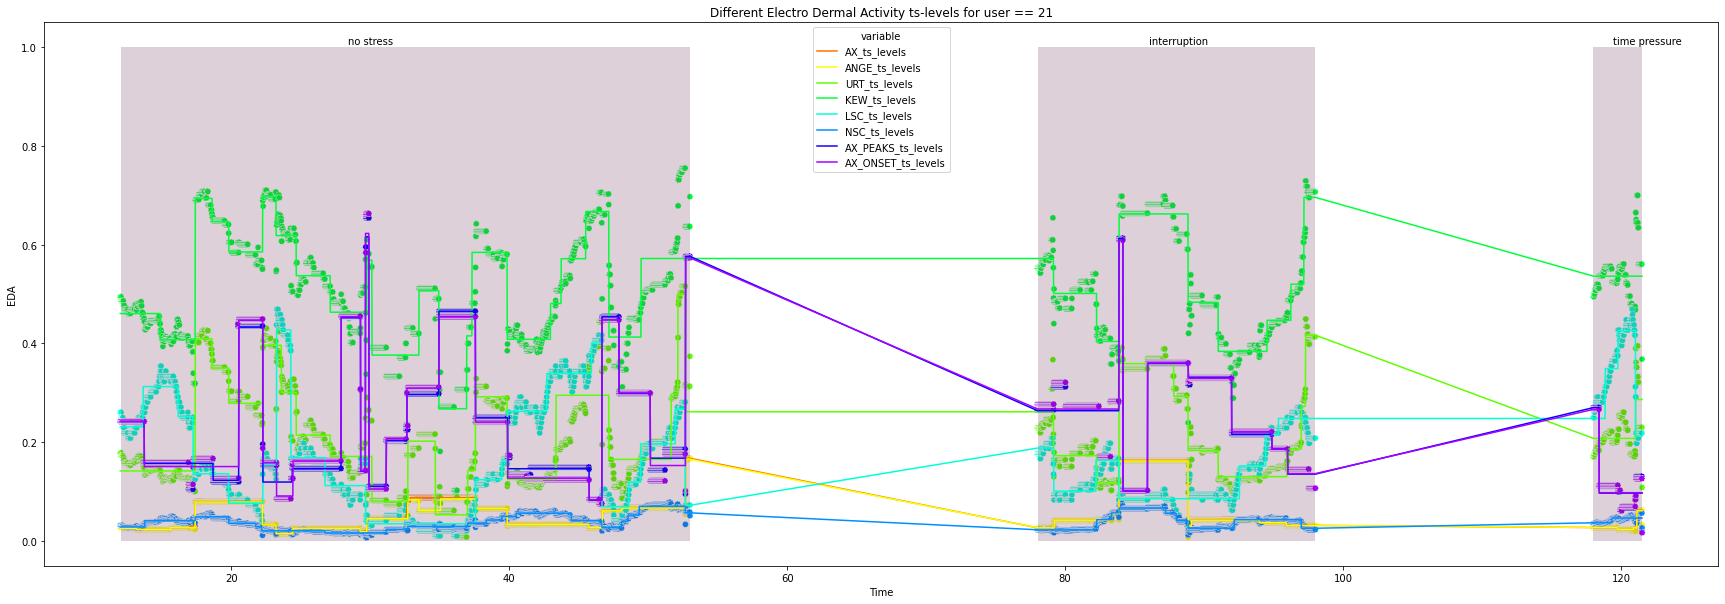

22
User == 22 plotted with errors
24


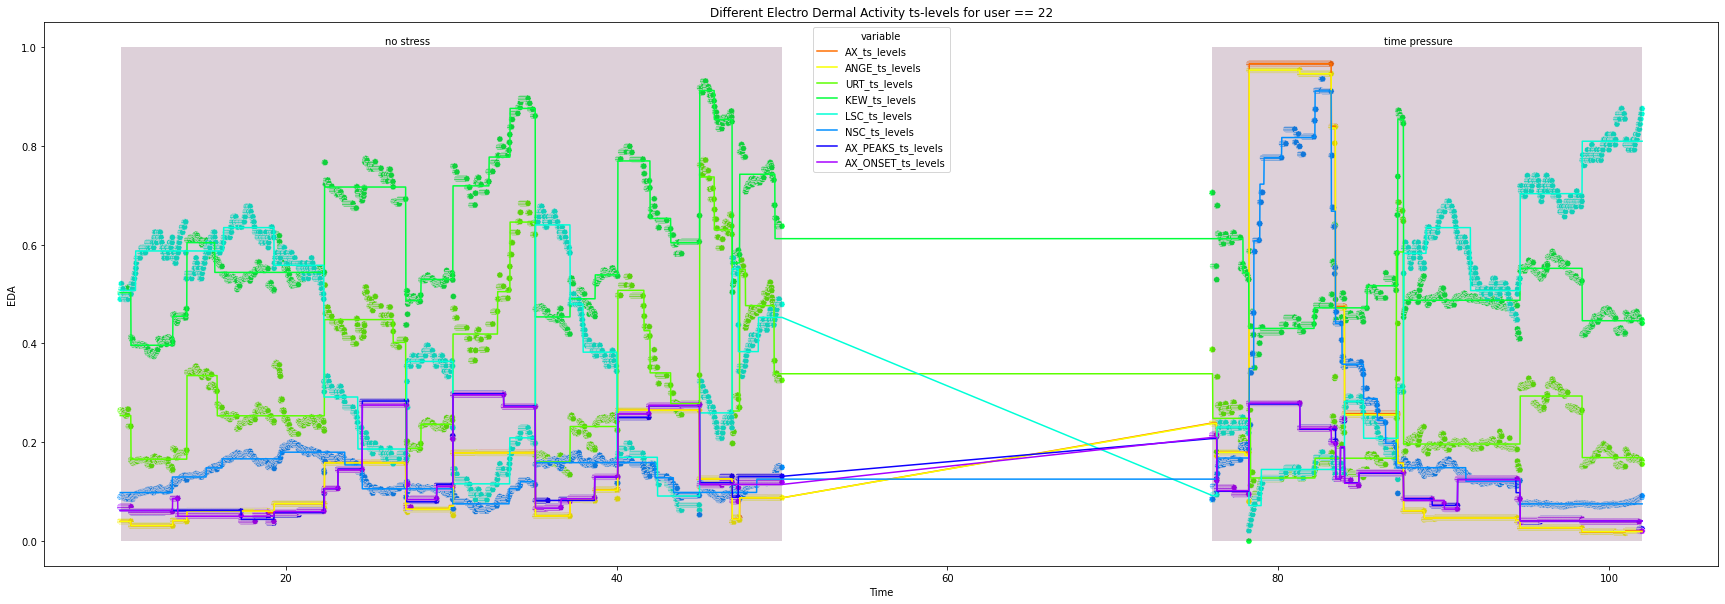

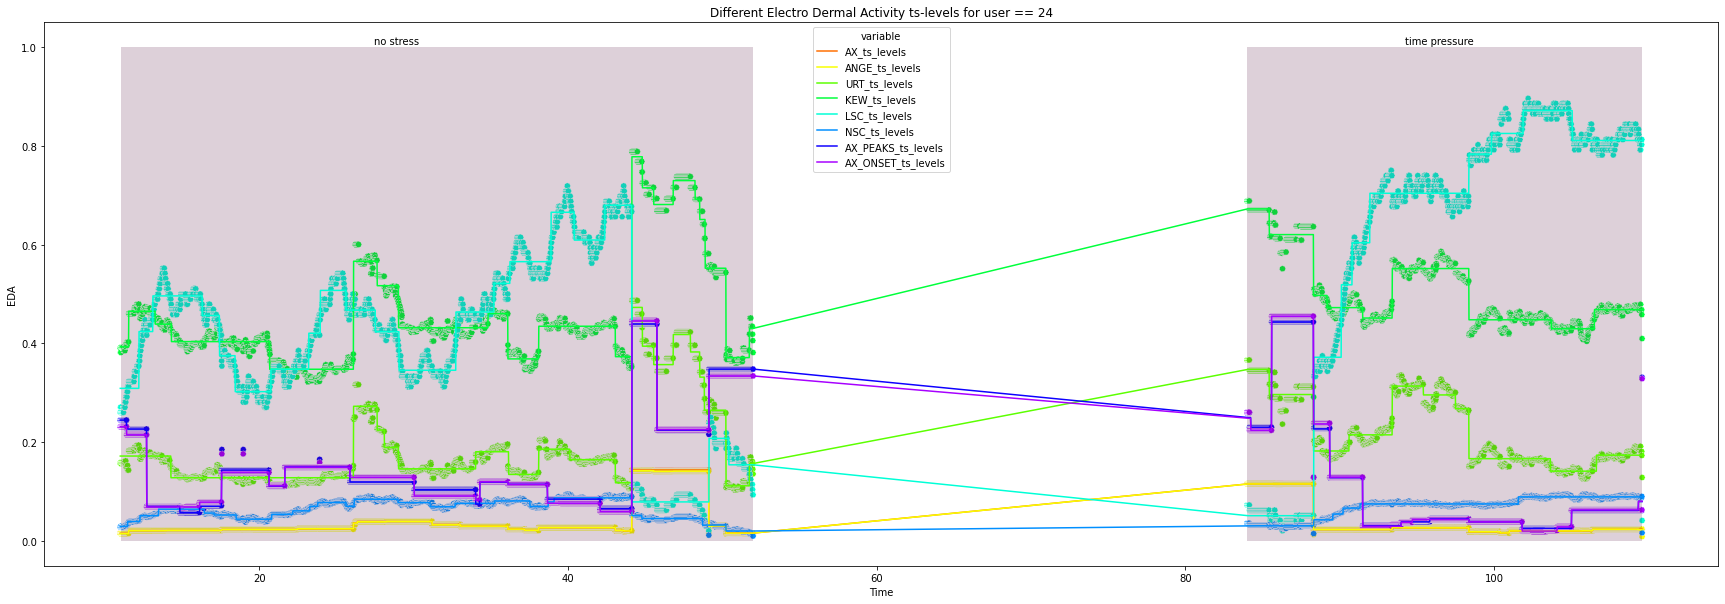

25


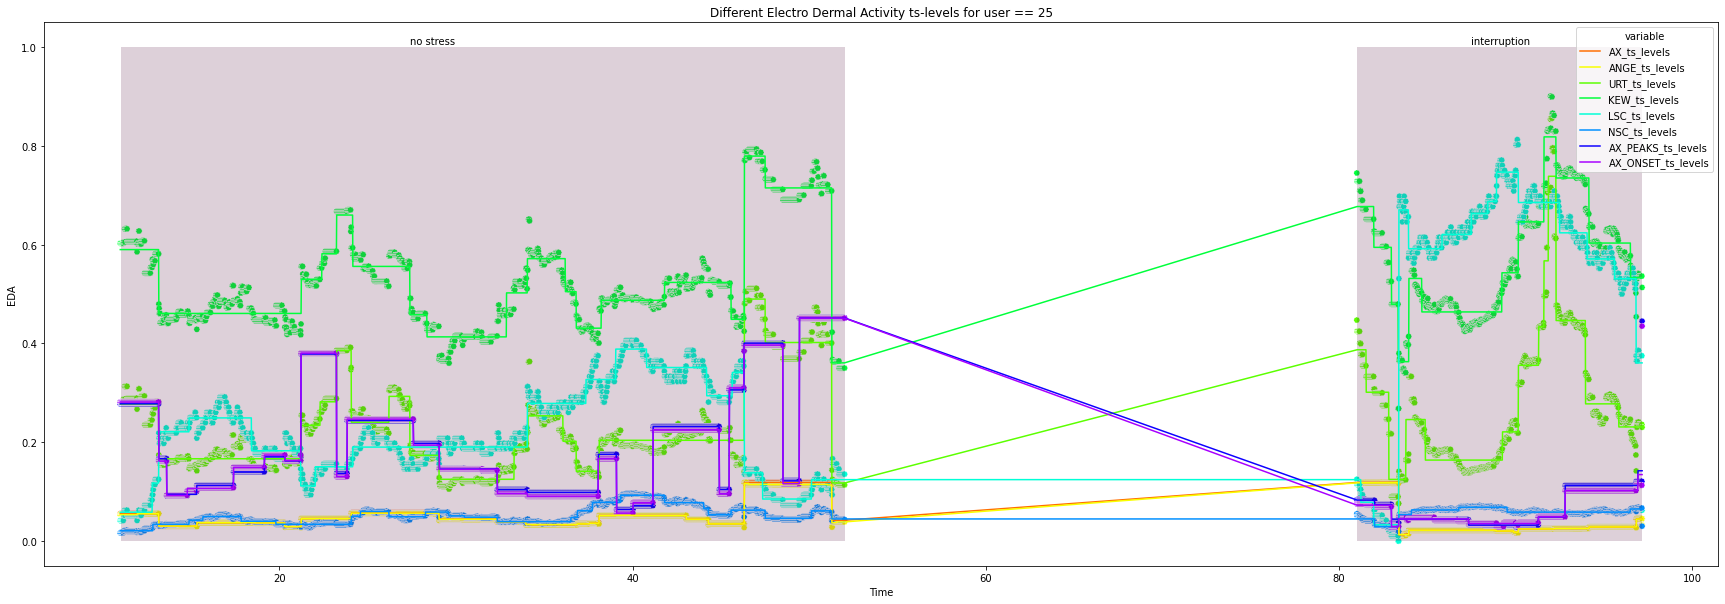

In [171]:
feature_selection = variance_summary[~variance_summary["discard"]].index.tolist()
# feature_selection = swell_eda_features_cols
for user in df["user_id"].unique().tolist():
    print(user)
    ts_df = df.loc[df["user_id"] == user, feature_selection + ["Time", "condition"]]

    all_ts_levels = pd.DataFrame()

    for column in feature_selection:
        ts_levels_df, fig, ax = ts_levels(ts=ts_df[column], 
                                      ts_x=None, 
                                      criterion="mse", 
                                      max_depth=10, 
                                      min_samples_leaf=15,
                                      min_samples_split=2, 
                                      max_leaf_nodes=30, 
                                      plot=False, 
                                      equal_spaced=True, 
                                      n_x_ticks=10)
        _ = ts_levels_df.set_index("t_steps", inplace=True)
        ts_levels_df.columns = [f"{column[1:]}_{x}" for x in ts_levels_df.columns.tolist()]
        all_ts_levels = pd.concat([all_ts_levels, ts_levels_df], axis=1)

    plot_df = (pd.merge(ts_df["Time"].reset_index(drop=True), 
             all_ts_levels, 
             left_index=True, 
             right_index=True)
           .melt(id_vars="Time"))

    try: 
        plt.figure(figsize=(30, 10))
        height=1
        ax = sns.scatterplot(x="Time", 
                          y="value",
                          hue="variable", 
                          palette="gist_rainbow",
                          data=plot_df[plot_df["variable"].str.contains("original_ts")],
                          legend=False,
                          linestyle='dashed',
                         )
        ax = sns.lineplot(x="Time", 
                          y="value",
                          hue="variable", 
                          palette="gist_rainbow",
                          data=plot_df[plot_df["variable"].str.contains("ts_levels")],
                         )
        _ = ax.set(xlabel='Time', ylabel='EDA', 
                   title=f'Different Electro Dermal Activity ts-levels for user == {user}')

        for condition in ts_df["condition"].unique().tolist():
            x_index = ts_df.loc[ts_df["condition"] == condition, "Time"].index.tolist()[0]+1
            x_co = ts_df.loc[x_index, "Time"]
            width = ts_df.loc[ts_df["condition"] == condition, "Time"].max() - x_co
            _ = ax.add_patch(patches.Rectangle((x_co, 0), width, height, alpha=0.2, facecolor="#581845"))
            _ = plt.text(x=x_co + 0.4*width, y=1.005, s=condition)

        _ = plt.show()
    except:
        print(f"User == {user} plotted with errors")